In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import floor
from keras import models
from keras import layers
from keras import optimizers
from scipy.integrate import odeint
import scipy

# Descenso del gradiente

In [2]:
#derivada parcial de una función:
#g=función
#k es la variable respecto a la que se deriva X=(x1, x2,..., xk,..)
#X es el punto en el que se evalua la derivada
def partial(g, k, X):
    h = 1e-10
    Y = np.copy(X)
    X[k - 1] = X[k - 1] + h
    dp = (g(X) - g(Y)) / h
    return dp

#Regresa el vector gradiente de una función f evaluando en X, tiene una cota para evitar que explote el valor del gradiente
#pero manteniendo la dirección del mismo
def gradcot(f, X, cota):
    grd = []
    for i in np.arange(0, len(X)):
        #aquí definiremos la cota para el gradiente 
        ai = partial(f, i + 1, X)
        ai=float(ai)
        if ai<0:
            ai = max(ai, -1*cota)
        else:
            ai = min(ai, cota)
        grd.append(ai)
    return grd

#esta función aplica el descenso del gradiente a una función f, comenzando en un punto X0
#eta=learning rate
#steps=número máximo de iteraciones a realizar
#tolerance=norma del vector gradiente en la que ya es buena idea terminar las iteraciones
def desgrad(f,X0,eta, steps, cota, tolerance):
    i=0
    while True:
        i=i+1
        X0=X0-eta*np.array(gradcot(f,X0, cota))

        if np.linalg.norm(gradcot(f,X0, cota))<tolerance or i>steps: break
        
        
    return X0

#nos arroja X0 donde la función debe tener un mínimo

# Descenso del gradiente aplicado a una regresión lineal
El archivo hubble_low_z.txt Contiene 18 supernovas cercanas (solo hasta el corrimiento al rojo $z \sim 1$ donde se encuentra que la relación de Hubble funciona bien. Aunque la ley de Hubble debería tener una ordenanda al origen de 0, ajustaremos una recta con ayuda del perceptrón.

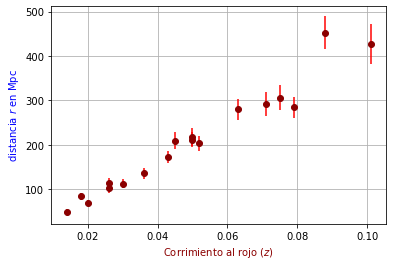

In [3]:
hubble=np.loadtxt('hubble_low_z.txt')
z,r,error=np.split(hubble,3, axis=1)

#graficamos
error=np.reshape(error.T,18)
plt.errorbar(z,r,fmt='o',yerr=error, ecolor='red',color='darkred')
#plt.plot(z,r,'o',color='darkred')
plt.xlabel('Corrimiento al rojo $(z)$',color='darkred')
plt.ylabel('distancia $r$ en Mpc',color='b')
plt.grid()

In [4]:
perceptron =lambda X,W: np.dot(X,W)

In [5]:
x=z
y1=r
x1=[]
for i in x:
    i=np.append(i,1.0)
    x1.append(i)
    
x1=np.array(x1)

In [6]:
def error(W,x=x1,y=r):
    s=0
    for i in range(0,len(y)):
        l=0.5*(np.dot(x1[i],W)-y[i])**2
        s=s+l
    return s


In [7]:
scipy.optimize.minimize(error, [1,1])

      fun: 5227.641727121165
 hess_inv: array([[ 0.77751465, -0.07124084],
       [-0.07124084,  0.04530579]])
      jac: array([-6.10351562e-05,  6.10351562e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 164
      nit: 17
     njev: 51
   status: 2
  success: False
        x: array([4448.86206485,  -12.43375591])

In [8]:
m,b=desgrad(error,[10,1],eta=0.1,steps=10000,tolerance=1e-8,cota=100.0)
print('La pendiente es',m,'y la ordenada es',b)

La pendiente es 4445.31428508585 y la ordenada es -12.258316395122959


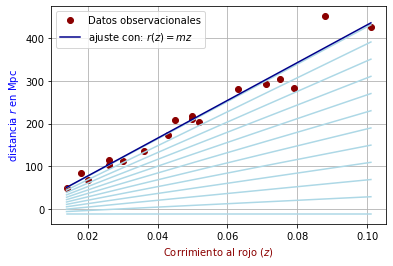

In [18]:
plt.plot(z,r,'o',label='Datos observacionales',color='darkred')
plt.xlabel('Corrimiento al rojo $(z)$',color='darkred')
plt.ylabel('distancia $r$ en Mpc',color='b')
for i in range(0,4445,400):
    plt.plot(z,i*z+b,color='lightblue')
plt.plot(z,m*z+b,label='ajuste con: $r(z)=mz$',color='darkblue')
plt.legend()
plt.grid()

In [15]:
index=np.append(np.arange(1,30,1), np.arange(40,10000,70))
def desgrad1(f,X0,eta, steps, cota, tolerance):
    i=0
    pendientes=[]
    while True:
        i=i+1
        X0=X0-eta*np.array(gradcot(f,X0, cota))

        if np.linalg.norm(gradcot(f,X0, cota))<tolerance or i>steps: break
        
        if i in index:
            pendientes.append(X0)
            
    return pendientes

In [24]:
A=desgrad1(error,[5000,30],eta=0.1,steps=10000,tolerance=1e-8,cota=100.0)

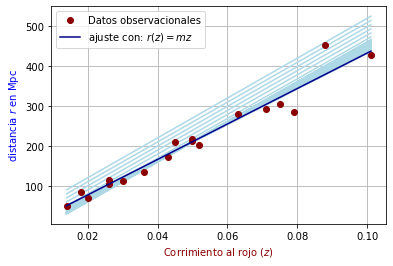

In [25]:
for a in A:
    m,b=a
    plt.plot(z,m*z+b,color='lightblue')
plt.plot(z,r,'o',label='Datos observacionales',color='darkred')
plt.plot(z,4445.53*z-12,label='ajuste con: $r(z)=mz$',color='darkblue')
plt.xlabel('Corrimiento al rojo $(z)$',color='darkred')
plt.ylabel('distancia $r$ en Mpc',color='b')
plt.grid()
plt.legend()

# Definición de las funciones de activación a utilizar


In [15]:
# RELU
def relu(x):
    return x * (x > 0)

def drelu(x):
    return 1. * (x > 0)

#IDENTIDAD
def iden(X):
    return X
def diden(X):
    return 1

#SIGMOIDE
def sigmoid(X):
    return 1/(1+np.exp(-X))
def dsigmoid(X):
    return sigmoid(X)*(1-sigmoid(X))

#TANGENTE HIPORBÓLICA
def tanh(X):
    return np.tanh(X)
def dtanh(X):
    return 1-tanh(X)**2


# Función split para separa un conjunto de datos X,Y
separa un conjunto X,Y en dos pares: $X_{train}$,$Y_{train}$

$X_{val}$,$Y_{val}$

In [16]:
def split(X,Y,porcent): #El porcentaje debe estar dado entre 0 y 1, será el porcentaje que mandará a entrenamiento
    n=floor(porcent*len(X))
    index=random.sample(range(len(X)),n)
    X_learn=[]
    Y_learn=[]
    for i in index:
        X_learn.append(X[i])
        Y_learn.append(Y[i])
    X_val=np.delete(X,index, axis=0)
    Y_val=np.delete(Y,index, axis=0)
    
    X_learn=np.array(X_learn)
    Y_learn=np.array(Y_learn)
    
    return X_learn,Y_learn,X_val,Y_val


# Definición del forward propagation
Este forward es para una red de una sola capa oculta 

In [17]:
#Definimos el forward propagation por si se quiere evaluar un determiado valor después de haber entrenado la red
def forward(X,W1,b1,W2,b2,activation):
    z1=np.dot(X,W1)+b1
    a1=activation(z1)
    z2=np.dot(a1,W2)+b2
    a2=z2
    return a2

# Función de coste

In [18]:
#función de coste:
def error(C):
    m=len(C)
    e=(1/(2*m))*np.linalg.norm(C)**2
    return e

# Red neuronal de una sola capa
X,Y= conjunto de datos
nodos=número de nodos que llevará la capa oculta
batch_size (Este debería decir split_size, pero no lo cambio para evitar errores)
activation=le decimos cuál de las funciones que definimos arriba queremos usar
así como su derivada correspondiente

#### Además de graficarnos el error, nos regresa los parámetros de la red W, b para su uso posterior

In [20]:
def neuralnet(X,Y,nodos,batch_size,learning_rate,epocas,activation,dactivation):
    #Definimos la estructura de la red
    n_entradas=len(X[0])
    n_salidas=len(Y[0])
    
    #definimos los conjuntos de aprendizaje y validación 
    X_learn,Y_learn,X_val,Y_val = split(X,Y,batch_size)
    
    #forward
    W1=np.random.randn(n_entradas,nodos)
    W2=np.random.randn(nodos,n_salidas)
    b1=np.random.randn(nodos)
    b2=np.random.randn(n_salidas)
    
    #z1=np.dot(X_learn,W1)+b1
    #a1=activation(z1)
    #z2=np.dot(a1,W2)+b2
    #a2=z2
    
    #épocas
    errores=[]
    validacion=[]
    for i in range(epocas+1):
        #Forward
        z1=np.dot(X_learn,W1)+b1
        a1=activation(z1)
        z2=np.dot(a1,W2)+b2
        a2=z2
        
        #backpropagation
        delta2 = a2-Y_learn
        delta1 = (delta2).dot(W2.T)*dactivation(z1)
        
        errores.append(error(delta2)) #guardamos el error de cada época

        W2 -= learning_rate * a1.T.dot(delta2)
        b2 -= learning_rate * (delta2).sum(axis=0)

        W1 -= learning_rate * X_learn.T.dot(delta1)
        b1 -= learning_rate * (delta1).sum(axis=0)
        print("Época %d, coste %f" %(int(i),error(delta2)))
        
        #Ahora validamos el modelo
        z1=np.dot(X_val,W1)+b1
        a1=activation(z1)
        z2=np.dot(a1,W2)+b2
        a2=z2
        delta = a2-Y_val
        validacion.append(error(delta))
        
    plt.plot(range(i+1),errores,color='darkcyan',label='Aprendizaje')
    plt.plot(range(i+1),validacion,color='darkred',label='Validación')
    plt.grid()
    plt.legend()
    return W1,b1,W2,b2

# Una red parecida, pero con Keras

In [19]:
nodos=10
split_size=0.8
learning_rate=0.1
epocas=100

#Separamos los datos en validación y entrenamiento
X_learn,Y_learn,X_val,Y_val=split(X,Y,split_size)

#Armamos el modelo con estructura 'Sequential'
model=models.Sequential()

#la primer capa recibe un numero solamente, usaremos sigmoide como función de activación para la capa oculta
capa1=layers.Dense(nodos, input_shape=(len(X[0]),),use_bias=1,activation='sigmoid')
#para la capa de salida usamos Id como activación
salida=layers.Dense(len(Y[0]),use_bias=1)

#armamos el modelo
model.add(capa1)
model.add(salida)
#Ahora definimos el paso de compilación, con learning rate=0.001
#Función de error cuadrático medio


model.compile(optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse')

#por último traemos los datos de entrenamiento y los procesamos con 'fit()'
history=model.fit(X_learn,Y_learn,validation_data=(X_val, Y_val),batch_size=4,epochs=epocas,shuffle=True)

error=history.history['loss']
exac=history.history['val_loss']
epochs=np.arange(0,len(error))
plt.plot(epochs,error,label='Error entrenamiento',color='darkblue')
plt.plot(epochs,exac,label='Error Validación',color='r')
plt.legend()
plt.grid()
plt.title('Error durante el entrenamiento',color='red')

Epoch 1/100
200/200 [==============================] - 2s 4ms/step - loss: 11468.8154 - val_loss: 375.8191
Epoch 2/100
200/200 [==============================] - 0s 1ms/step - loss: 282.3834 - val_loss: 48.5691
Epoch 3/100
200/200 [==============================] - 0s 1ms/step - loss: 23.6279 - val_loss: 22.0794
Epoch 4/100
200/200 [==============================] - 0s 950us/step - loss: 14.9187 - val_loss: 13.0894
Epoch 5/100
200/200 [==============================] - 0s 895us/step - loss: 13.9879 - val_loss: 4.9340
Epoch 6/100
200/200 [==============================] - 0s 869us/step - loss: 12.4391 - val_loss: 9.8411
Epoch 7/100
200/200 [==============================] - 0s 905us/step - loss: 11.4783 - val_loss: 2.8511
Epoch 8/100
200/200 [==============================] - 0s 849us/step - loss: 10.3273 - val_loss: 1.1471
Epoch 9/100
200/200 [==============================] - 0s 905us/step - loss: 10.8674 - val_loss: 2.7063
Epoch 10/100
200/200 [==============================] - 0s 90

KeyboardInterrupt: 

# Ajuste a la ecuación de Friedmann con ambas redes

###### Importamos los datos para esta sección


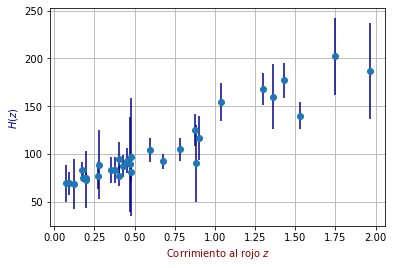

In [11]:
datosH=low_z=np.loadtxt('datosH.txt')

zH0,H,errorH0=np.split(datosH,3,axis=1)
errorH0=np.reshape(errorH0.T,31)
plt.errorbar(zH0,H,fmt='o',yerr=errorH0, ecolor='darkblue')
plt.xlabel('Corrimiento al rojo $z$', color='darkred')
plt.ylabel('$H(z)$', color='darkblue')
plt.grid()

In [12]:
#Función a emular
def Hlcdm(z, Om=0.27, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)


X=2.3*np.random.rand(1000,1)
Y=Hlcdm(X, Om=0.27, H0=73.24)

# Con la red trucha

Época 0, coste 10576.689567
Época 1, coste 8866.205419
Época 2, coste 7127.666200
Época 3, coste 5479.115285
Época 4, coste 4138.842736
Época 5, coste 3130.213395
Época 6, coste 2422.114877
Época 7, coste 1936.579044
Época 8, coste 1604.907967
Época 9, coste 1376.679290
Época 10, coste 1216.427046
Época 11, coste 1099.205267
Época 12, coste 1007.284209
Época 13, coste 928.719654
Época 14, coste 856.615960
Época 15, coste 786.757073
Época 16, coste 718.123537
Época 17, coste 654.098419
Época 18, coste 598.009350
Época 19, coste 548.152653
Época 20, coste 502.552065
Época 21, coste 460.797781
Época 22, coste 422.883476
Época 23, coste 388.695059
Época 24, coste 357.941700
Época 25, coste 330.287454
Época 26, coste 305.406422
Época 27, coste 282.992348
Época 28, coste 262.765098
Época 29, coste 244.474175
Época 30, coste 227.898537
Época 31, coste 212.844444
Época 32, coste 199.142598
Época 33, coste 186.645161
Época 34, coste 175.222928
Época 35, coste 164.762776
Época 36, coste 155.1654

Época 330, coste 6.284405
Época 331, coste 5.944129
Época 332, coste 6.266005
Época 333, coste 5.923802
Época 334, coste 6.243480
Época 335, coste 5.899831
Época 336, coste 6.216742
Época 337, coste 5.872168
Época 338, coste 6.185776
Época 339, coste 5.840827
Época 340, coste 6.150632
Época 341, coste 5.805881
Época 342, coste 6.111429
Época 343, coste 5.767455
Época 344, coste 6.068341
Época 345, coste 5.725722
Época 346, coste 6.021596
Época 347, coste 5.680901
Época 348, coste 5.971468
Época 349, coste 5.633244
Época 350, coste 5.918266
Época 351, coste 5.583034
Época 352, coste 5.862329
Época 353, coste 5.530576
Época 354, coste 5.804018
Época 355, coste 5.476190
Época 356, coste 5.743705
Época 357, coste 5.420203
Época 358, coste 5.681768
Época 359, coste 5.362947
Época 360, coste 5.618583
Época 361, coste 5.304749
Época 362, coste 5.554521
Época 363, coste 5.245929
Época 364, coste 5.489938
Época 365, coste 5.186795
Época 366, coste 5.425175
Época 367, coste 5.127639
Época 368, c

Época 692, coste 2.216477
Época 693, coste 2.154096
Época 694, coste 2.205955
Época 695, coste 2.144117
Época 696, coste 2.195493
Época 697, coste 2.134195
Época 698, coste 2.185095
Época 699, coste 2.124334
Época 700, coste 2.174765
Época 701, coste 2.114537
Época 702, coste 2.164506
Época 703, coste 2.104807
Época 704, coste 2.154322
Época 705, coste 2.095149
Época 706, coste 2.144215
Época 707, coste 2.085563
Época 708, coste 2.134189
Época 709, coste 2.076054
Época 710, coste 2.124245
Época 711, coste 2.066622
Época 712, coste 2.114387
Época 713, coste 2.057271
Época 714, coste 2.104616
Época 715, coste 2.048002
Época 716, coste 2.094933
Época 717, coste 2.038816
Época 718, coste 2.085341
Época 719, coste 2.029715
Época 720, coste 2.075839
Época 721, coste 2.020699
Época 722, coste 2.066430
Época 723, coste 2.011769
Época 724, coste 2.057113
Época 725, coste 2.002926
Época 726, coste 2.047889
Época 727, coste 1.994171
Época 728, coste 2.038758
Época 729, coste 1.985502
Época 730, c

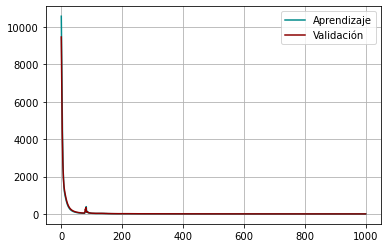

In [21]:
W1,b1,W2,b2=neuralnet(X,Y,10,0.2,0.0001,1000,activation=sigmoid,dactivation=dsigmoid)

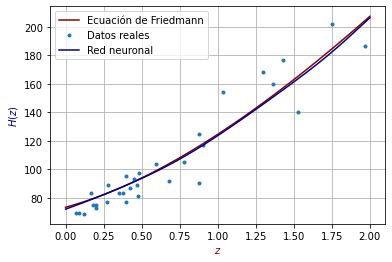

In [22]:
z=np.linspace(0,2,60)
z=z.reshape(60,1)
plt.plot(z,Hlcdm(z, Om=0.27, H0=73.24),color='darkred',label='Ecuación de Friedmann')
plt.plot(zH0,H,'.', label='Datos reales')
plt.plot(z,forward(z,W1,b1,W2,b2,sigmoid),label='Red neuronal',color='darkblue')
plt.xlabel('$z$', color='darkred')
plt.ylabel('$H(z)$', color='darkblue')
plt.legend()
plt.grid()

# Con Keras

Epoch 1/100
200/200 [==============================] - 1s 1ms/step - loss: 10589.1734 - val_loss: 507.5878
Epoch 2/100
200/200 [==============================] - 0s 729us/step - loss: 236.8335 - val_loss: 38.9420
Epoch 3/100
200/200 [==============================] - 0s 729us/step - loss: 20.7373 - val_loss: 12.4615
Epoch 4/100
200/200 [==============================] - 0s 719us/step - loss: 14.8846 - val_loss: 5.7551
Epoch 5/100
200/200 [==============================] - 0s 719us/step - loss: 11.0232 - val_loss: 14.6339
Epoch 6/100
200/200 [==============================] - 0s 729us/step - loss: 11.5846 - val_loss: 1.7248
Epoch 7/100
200/200 [==============================] - 0s 729us/step - loss: 11.0040 - val_loss: 3.8548
Epoch 8/100
200/200 [==============================] - 0s 709us/step - loss: 8.8489 - val_loss: 8.8836
Epoch 9/100
200/200 [==============================] - 0s 709us/step - loss: 9.3161 - val_loss: 1.1389
Epoch 10/100
200/200 [==============================] - 0s 

Text(0.5, 1.0, 'Error durante el entrenamiento')

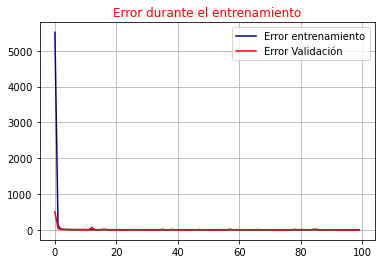

In [28]:
nodos=10
split_size=0.8
learning_rate=0.1
epocas=100

#Separamos los datos en validación y entrenamiento
X_learn,Y_learn,X_val,Y_val=split(X,Y,split_size)

#Armamos el modelo con estructura 'Sequential'
model=models.Sequential()

#la primer capa recibe un numero solamente, usaremos sigmoide como función de activación para la capa oculta
capa1=layers.Dense(nodos, input_shape=(len(X[0]),),use_bias=1,activation='sigmoid')
#para la capa de salida usamos Id como activación
salida=layers.Dense(len(Y[0]),use_bias=1)

#armamos el modelo
model.add(capa1)
model.add(salida)
#Ahora definimos el paso de compilación, con learning rate=0.001
#Función de error cuadrático medio


model.compile(optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse')

#por último traemos los datos de entrenamiento y los procesamos con 'fit()'
history=model.fit(X_learn,Y_learn,validation_data=(X_val, Y_val),batch_size=4,epochs=epocas,shuffle=True)

error=history.history['loss']
exac=history.history['val_loss']
epochs=np.arange(0,len(error))
plt.plot(epochs,error,label='Error entrenamiento',color='darkblue')
plt.plot(epochs,exac,label='Error Validación',color='r')
plt.legend()
plt.grid()
plt.title('Error durante el entrenamiento',color='red')

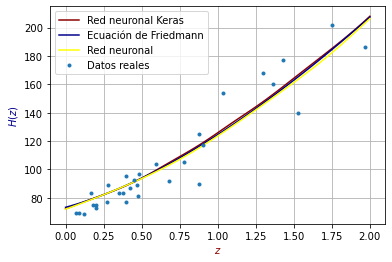

In [30]:
z=np.linspace(0,2,60)
z=z.reshape(60,1)
plt.plot(z,model.predict(z),label='Red neuronal Keras',color='darkred')
plt.plot(z,Hlcdm(z, Om=0.27, H0=73.24),color='darkblue',label='Ecuación de Friedmann')
plt.plot(z,forward(z,W1,b1,W2,b2,sigmoid),label='Red neuronal',color='yellow')
plt.plot(zH0,H,'.', label='Datos reales')
plt.xlabel('$z$', color='darkred')
plt.ylabel('$H(z)$', color='darkblue')
plt.grid()
plt.legend()

# Entrenamiento con ecuaciones diferenciales

#### Sistema de ecuaciones
Resolver:

$\dot \rho_i + 3(1+\gamma)H\rho_i = 0$

$H^2 = \frac{\kappa_0}{3}\sum \rho_i$

Cambiando variables, a:

$\Omega_i = \frac{\kappa_0 }{3H^2} \rho_i$ 

# 1. Transformamos la EDO en una función

In [18]:
def RHS(Omega_i, lna, gamma=0):
    x, y, z, H = Omega_i
    #x, y, z = Omega_i
    pi = 3*x + 4*y
    return [x*(-3 + pi), y*(-4 + pi), z*pi, -0.5*H*pi]
    #return [x*(-3 + pi), y*(-4 + pi), z*pi]

def EDO(t,Om,H0):
    #t,Or,Om,Ol=X
    Or=0.0001
    Ol=1-Or-Om
    #H0 = 70.
    y0 = [Om, Or, Ol, H0]
    result = odeint(RHS, y0, t)
    return result

# 2. Gneramos el conjunto de datos 
Con las suficientes combinaciones de $\Omega _i$ como para que el algrtimo aprenda
Vamos a variar 



$O_m \in [0.1, 0.5]$

$H_0 \in [65, 80]$

$t \in [0,-12]$



In [19]:
#O_m=np.linspace(0.1,0.5,50)
O_m=np.arange(0.1,0.51,0.01)
#O_r=np.linspace(0.0001,0.0010,50)
#O_r=np.arange(0.0001,0.0010,0.0001)
H_0=np.arange(66,81,1)
t=np.linspace(0,-12,50)

##### hacemos la combinatoria de estos conjuntos

In [20]:
Y0=[]
#este ciclo llena la lista fijando un Om y pasando todos los Or
for i in O_m:
    for j in H_0:
        Y0.extend(EDO(t,i,j))
Y0=np.array(Y0)

X0=[]
for Om in O_m:
    for H0 in H_0:
        for T in t:
            X0.append([T,Om,H0])
X0=np.array(X0)

#### Como la cuarta componente de las soluciones toma valores muy grandes, vamos a estandarizar al conjunto Y con una transformación de máximo-mínimo. Luego al evaluarla será necesario aplicar la transformación inversa a la salida de la red

In [21]:
from sklearn import preprocessing


In [22]:
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
Y2 = scaler.fit_transform(Y0)

Se usó la siguiente estructura de red, ya no la corro, pero adjunto el modelo y el error que tuvo durante las épocas
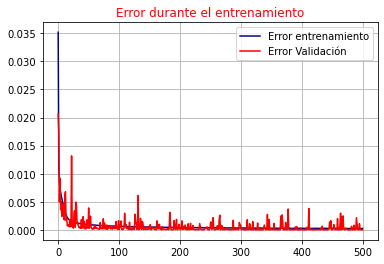

In [ ]:
#Dos paredes ocultas
nodos=150
split_size=0.8
learning_rate=0.001
epocas=500

#Separamos los datos en validación y entrenamiento
X_learn,Y_learn,X_val,Y_val=split(X0,Y2,split_size)

#Armamos el modelo con estructura 'Sequential'
model=models.Sequential()

#la primer capa recibe un numero solamente, usaremos sigmoide como función de activación para la capa oculta
capa1=layers.Dense(nodos, input_shape=(3,),use_bias=1,activation='sigmoid')
capa2=layers.Dense(nodos,use_bias=1,activation='sigmoid')
capa3=layers.Dense(nodos,use_bias=1,activation='sigmoid')
capa4=layers.Dense(nodos,use_bias=1,activation='sigmoid')
#para la capa de salida usamos Id como activación
salida=layers.Dense(4,use_bias=1)

#armamos el modelo
model.add(capa1)
model.add(capa2)
model.add(capa3)
model.add(capa4)
model.add(salida)
#Ahora definimos el paso de compilación, con learning rate=0.001
#Función de error cuadrático medio


model.compile(optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse')

#por último traemos los datos de entrenamiento y los procesamos con 'fit()'
history=model.fit(X_learn,Y_learn,validation_data=(X_val, Y_val),epochs=epocas)

error=history.history['loss']
exac=history.history['val_loss']
epochs=np.arange(0,len(error))
plt.plot(epochs,error,label='Error entrenamiento',color='darkblue')
plt.plot(epochs,exac,label='Error Validación',color='r')
plt.legend()
plt.grid()
plt.title('Error durante el entrenamiento',color='red')

## El modelo guardado de este proceso:

In [2]:
model = models.load_model('modelo_final.h5')

##### 1. Comparación entre el modelo y los datos reales

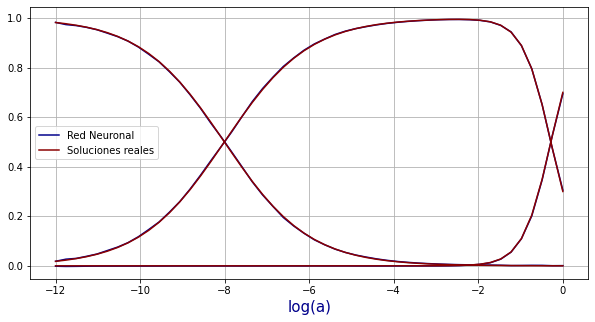

In [85]:
Z=np.linspace(0,-12,50)
dom=[]
dom2=[]
dom3=[]
#Distintas combinaciones de los hiperparámetros, para el modelo keras

for z in Z: dom.append([z,0.5,80]) 
A=model.predict(dom)
A=scaler.inverse_transform(A)

for z in Z: dom2.append([z,0.3,70]) 
B=model.predict(dom2)
B=scaler.inverse_transform(B)

for z in Z: dom3.append([z,0.4,67]) 
C=model.predict(dom3)
C=scaler.inverse_transform(C)
#función real
D=EDO(Z, 0.3,70)



#Comparación entre la real y el modelo
plt.figure(figsize=(10,5))
plt.plot(Z,B[:,0],color='darkblue')
plt.plot(Z,B[:,1],color='darkblue')
plt.plot(Z,B[:,2],color='darkblue', label='Red Neuronal')
#plt.plot(Z,B[:,3])


plt.plot(Z,D[:,0],color='darkred')
plt.plot(Z,D[:,1],color='darkred')
plt.plot(Z,D[:,2],color='darkred', label='Soluciones reales')
#plt.plot(Z,D[:,3])

#plt.title()
plt.xlabel('log(a)', size=15, color='darkblue')
plt.grid()
plt.legend()

##### 2. Soluciones dadas por la red para $O_{m,0}=0.3$ y $H_0=70$

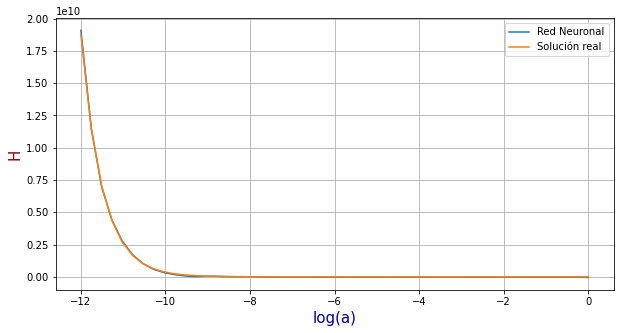

In [93]:
#Comparación entre la real y el modelo
plt.figure(figsize=(10,5))
plt.plot(Z,B[:,3], label='Red Neuronal')
plt.plot(Z,D[:,3], label='Solución real')

#plt.title()
plt.xlabel('log(a)', size=15, color='darkblue')
plt.ylabel('H', size=15, color='darkred')
plt.grid()
plt.legend()

##### 2.1 Cuarta Solución 

In [ ]:
#Comparación entre la real y el modelo
plt.figure(figsize=(10,5))
plt.plot(Z,B[:,0],label='$\Omega_m$')

plt.plot(Z,B[:,2],label='$\Omega_\Lambda$')
#plt.plot(Z,B[:,3])

#plt.title()
plt.xlabel('log(a)', size=15, color='darkblue')
plt.grid()
plt.legend()

##### 3. Soluciones para distintos $O_m$ y $H_0$

Text(0.5, 0, 'log(a)')

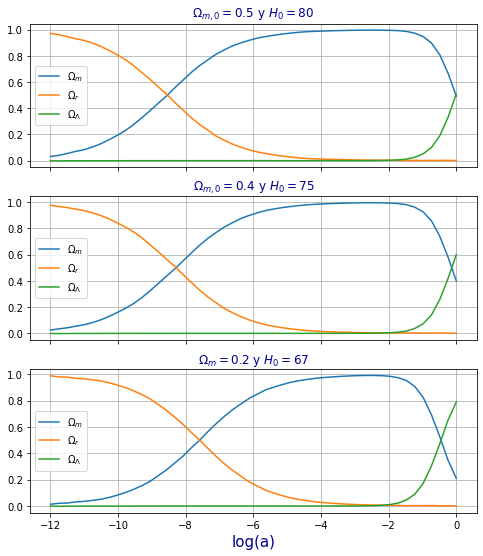

In [84]:
Z=np.linspace(0,-12,50)
dom=[]
dom2=[]
dom3=[]
#Distintas combinaciones de los hiperparámetros, para el modelo keras
for z in Z: dom.append([z,0.5,80]) 
A=model.predict(dom)
A=scaler.inverse_transform(A)

for z in Z: dom2.append([z,0.4,75]) 
B=model.predict(dom2)
B=scaler.inverse_transform(B)

for z in Z: dom3.append([z,0.2,67]) 
C=model.predict(dom3)
C=scaler.inverse_transform(C)

#Gráficas
fig, (ax1, ax2,ax3) = plt.subplots(3, sharex=True, figsize=(8,9))
#fig.suptitle('Soluciones a distintos parámetros', color='darkblue')
ax1.plot(Z, A[:,0], label='$\Omega_m$')
ax1.plot(Z, A[:,1],label='$\Omega_r$')
ax1.plot(Z, A[:,2],label='$\Omega_\Lambda$')
ax1.grid()
ax1.legend()
ax1.set_title('$\Omega_{m,0} = 0.5$ y $H_0 = 80$', color='darkblue')

ax2.plot(Z, B[:,0], label='$\Omega_m$')
ax2.plot(Z, B[:,1],label='$\Omega_r$')
ax2.plot(Z, B[:,2],label='$\Omega_\Lambda$')
ax2.grid()
ax2.legend()
ax2.set_title('$\Omega_{m,0} = 0.4$ y $H_0 = 75$', color='darkblue')

ax3.plot(Z, C[:,0], label='$\Omega_m$')
ax3.plot(Z, C[:,1],label='$\Omega_r$')
ax3.plot(Z, C[:,2],label='$\Omega_\Lambda$')
ax3.set_title('$\Omega_m = 0.2$ y $H_0 = 67$', color='darkblue')
ax3.legend()
ax3.grid()
plt.xlabel('log(a)', size=15, color='darkblue')


# Comparación de tiempo de cómputo
Primero transformamos a la función EDO en una función que pueda aplicarse a un array.

In [17]:
def RHS(Omega_i, lna, gamma=0):
    x, y, z, H = Omega_i
    #x, y, z = Omega_i
    pi = 3*x + 4*y
    return [x*(-3 + pi), y*(-4 + pi), z*pi, -0.5*H*pi]
    #return [x*(-3 + pi), y*(-4 + pi), z*pi]

def EDO(X):
    Om,H0=X
    t=np.linspace(0,-12,50)
    #t,Or,Om,Ol=X
    Or=0.0001
    Ol=1-Or-Om
    #H0 = 70.
    y0 = [Om, Or, Ol, H0]
    result = odeint(RHS, y0, t)
    return result

Aquí generamos los datos que le daremos a la red y a la EDO

In [34]:
#O_m=np.arange(0.1,0.51,0.01)
#H_0=np.arange(66,81,1)
O_m=np.linspace(0.1,0.51,100)
H_0=np.linspace(66,81,100)
t=np.linspace(0,-12,50)

X0=[]
X1=[]
for Om in O_m:
    for H0 in H_0:
        X1.append([Om,H0])
        for T in t:
            X0.append([T,Om,H0])
X0=np.array(X0) #para la red
X1=np.array(X1) #para EDO

Ahora medimos el tiempo que toma la red en generarnos las soluciones para 10000 condiciones iniciales distintas.

In [38]:
import time

In [39]:
inicio = time.time()

model.predict(X0)

fin = time.time()
print(fin-inicio)

7.1615376472473145


Ahora mediermos cuánto tarda EDO al evaluar esas 10000 condiciones iniciales, considerando el tiempo que toma mostras o extrarlas del iterable map

In [40]:
inicio = time.time()

list(map(EDO,X1))

fin = time.time()
print(fin-inicio)

15.642190217971802
